In [60]:
'''
Author: Yu Tian

The purpose of this project is to utilize NLP techniques to predict the selection of 
comments on New York Times articles as editior's picks. 
'''

import numpy as np
import pandas as pd
import gc
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import (roc_auc_score, classification_report, log_loss, make_scorer, 
                             recall_score, precision_recall_curve, roc_curve)

# 0. Load Data

In [59]:
data1 = pd.read_csv('./Data/CommentsJan2017.csv')
data2 = pd.read_csv('./Data/CommentsFeb2017.csv')
data3 = pd.read_csv('./Data/CommentsMarch2017.csv')
data4 = pd.read_csv('./Data/CommentsApril2017.csv')
data5 = pd.read_csv('./Data/CommentsMay2017.csv')
data6 = pd.read_csv('./Data/CommentsJan2018.csv')
data7 = pd.read_csv('./Data/CommentsFeb2018.csv')
data8 = pd.read_csv('./Data/CommentsMarch2018.csv')
data9 = pd.read_csv('./Data/CommentsApril2018.csv')

# concatenate the comments that are from different months in 2018
data = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9])
data.drop_duplicates(subset='commentID', inplace=True)
data.reset_index(drop=True, inplace=True)

/Users/ty/anaconda/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14,15,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ty/anaconda/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ty/anaconda/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ty/anaconda/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  inte

Take a look at the shape of data

In [61]:
data.shape

(2118617, 34)

Look at the features

In [62]:
data.columns

Index(['approveDate', 'articleID', 'articleWordCount', 'commentBody',
       'commentID', 'commentSequence', 'commentTitle', 'commentType',
       'createDate', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk',
       'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'printPage',
       'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag',
       'sectionName', 'sharing', 'status', 'timespeople', 'trusted',
       'typeOfMaterial', 'updateDate', 'userDisplayName', 'userID',
       'userLocation', 'userTitle', 'userURL'],
      dtype='object')

In [63]:
data.head()

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,...,status,timespeople,trusted,typeOfMaterial,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1483455908,58691a5795d0e039260788b9,1324.0,For all you Americans out there --- still rejo...,20969730.0,20969730.0,<br/>,comment,1.483426e+09,1.0,...,approved,1.0,0.0,News,1483455908,N. Smith,64679318.0,New York City,NaN,NaN
1,1483455656,58691a5795d0e039260788b9,1324.0,Obamas policies may prove to be the least of t...,20969325.0,20969325.0,<br/>,comment,1.483417e+09,1.0,...,approved,1.0,0.0,News,1483455656,Kilocharlie,69254188.0,Phoenix,NaN,NaN
2,1483455655,58691a5795d0e039260788b9,1324.0,Democrats are comprised of malcontents who gen...,20969855.0,20969855.0,<br/>,comment,1.483431e+09,1.0,...,approved,1.0,0.0,News,1483455655,Frank Fryer,76788711.0,Florida,NaN,NaN
3,1483455653,58691a5795d0e039260788b9,1324.0,The picture in this article is the face of con...,20969407.0,20969407.0,<br/>,comment,1.483419e+09,1.0,...,approved,1.0,0.0,News,1483455653,James Young,72718862.0,Seattle,NaN,NaN
4,1483455216,58691a5795d0e039260788b9,1324.0,Elections have consequences.,20969274.0,20969274.0,NaN,comment,1.483417e+09,1.0,...,approved,1.0,0.0,News,1483455216,M.,7529267.0,Seattle,NaN,NaN


The feature 'commentBody' contains the text of comments and will be used later

# 1. Processing

### 1.0 Check balance

First take a look at the distribution of classes:

In [25]:
data.editorsSelection.value_counts()

0    2078255
1      40362
Name: editorsSelection, dtype: int64

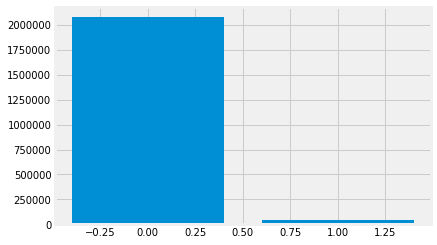

In [24]:
plt.bar(data.editorsSelection.value_counts().keys().tolist(),
        data.editorsSelection.value_counts().values.tolist())
plt.show()

The data is very unbalanced. To deal with that situlation, undersampling the data that have majority samples. Select all positive data (comments that indeed were editor's pick), and set the number of negative data (not editor's pick) to be around 3 folds.

In [64]:
def balancing(data):
    pos = data.loc[data.editorsSelection == True]
    n = round(pos.shape[0]*3)
    if n:        
        try:
            neg = data.loc[data.editorsSelection == False].sample(n)
        except: 
            neg = data.loc[data.editorsSelection == False]
        res = pd.concat([pos, neg])
        return res
    else:
        return None 

In [65]:
new = data.groupby('articleID').apply(balancing).reset_index(drop=True)

Take a look at the new distribution:

In [77]:
new.editorsSelection.value_counts()

0    121021
1     40362
Name: editorsSelection, dtype: int64

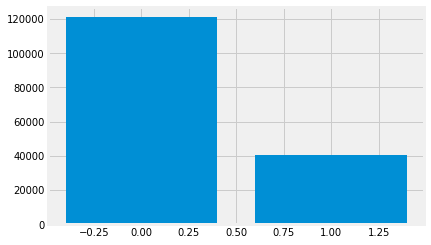

In [66]:
plt.bar(new.editorsSelection.value_counts().keys().tolist(),
        new.editorsSelection.value_counts().values.tolist())
plt.show()

# 2. Training

Using commentBody as X and editiorsSelection as Y. Use the article ID to track data and split: 

In [67]:
commentBody = new.commentBody
nytpicks = new.editorsSelection
articleID = new.articleID

In [69]:
for train_index, test_index in GroupKFold(n_splits=5).split(commentBody, nytpicks, groups=articleID):
    train_text, test_text = commentBody[train_index], commentBody[test_index] 
    train_target, test_target = nytpicks[train_index], nytpicks[test_index]
    train_groups, test_groups = articleID[train_index], articleID[test_index]
    
train_text.shape[0], test_text.shape[0]

(129107, 32276)

Using TFIDF for words and character n-grams and combine them using FeatureUnion

In [70]:
vectorizer = FeatureUnion([
    ('word_tfidf', TfidfVectorizer(
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=600,
    )),
    
    ('char_tfidf', TfidfVectorizer(
    analyzer='char',
    ngram_range=(2, 4),
    max_features=600,
    ))
])
start_vect = time()
vectorizer.fit(commentBody)
train_text = vectorizer.transform(train_text)
test_text = vectorizer.transform(test_text)

print("Vectorization Runtime: %0.2f Minutes"%((time() - start_vect)/60))

Vectorization Runtime: 6.85 Minutes


Use Latent Semantic Analysis to perform dimensionality reduction on the tf-idf vectors and then train the Logistic regression to make predictions.

In [71]:
clf_logistic = Pipeline([
    ('lsa', TruncatedSVD(n_components=1000, random_state=0)), 
    ('logistic', LogisticRegression(C=150))  
])

Tune hyper-parameters using grid search:

In [72]:
param_grid = [
    {'logistic__C': [150, 200]}
]

In [73]:
gkf = GroupKFold(n_splits=3).split(train_text, train_target, groups=train_groups)
scorer = make_scorer(recall_score)

grid_search = GridSearchCV(clf_logistic, param_grid=param_grid, cv=gkf, scoring=scorer)
grid_search.fit(train_text, train_target)

print("Best parameters found:")
print(grid_search.best_params_)
print("Best score:")
print(grid_search.best_score_)

test_prediction = grid_search.predict(test_text)
print(classification_report(test_target, test_prediction))

test_prediction_proba = grid_search.predict_proba(test_text)[:, 1]
score = roc_auc_score(test_target, test_prediction_proba)
print("ROC AUC Score: ", round(score, 4)) 

score = log_loss(test_target, test_prediction_proba)
print("logloss: ", round(score, 4))

Best parameters found:
{'logistic__C': 200}

Best score:
0.14194786219966077

             precision    recall  f1-score   support

          0       0.77      0.96      0.85     24207
          1       0.54      0.14      0.23      8069

avg / total       0.71      0.76      0.70     32276

ROC AUC Score:  0.7267
logloss:  0.5013


In [74]:
clf_logistic.fit(train_text, train_target)

test_prediction = clf_logistic.predict(test_text)
print("Classification report:")
print(classification_report(test_target, test_prediction))

test_prediction_proba = clf_logistic.predict_proba(test_text)[:, 1]
score = roc_auc_score(test_target, test_prediction_proba)
print("ROC AUC Score: ", round(score, 4)) 

score = log_loss(test_target, test_prediction_proba)
print("logloss: ", round(score, 4))

Classification report:
             precision    recall  f1-score   support

          0       0.77      0.96      0.85     24207
          1       0.54      0.14      0.23      8069

avg / total       0.71      0.76      0.70     32276

ROC AUC Score:  0.7267
logloss:  0.5013


In [81]:
p, r, _ = precision_recall_curve(test_target, test_prediction_proba)
tpr, fpr, _ = roc_curve(test_target, test_prediction_proba)

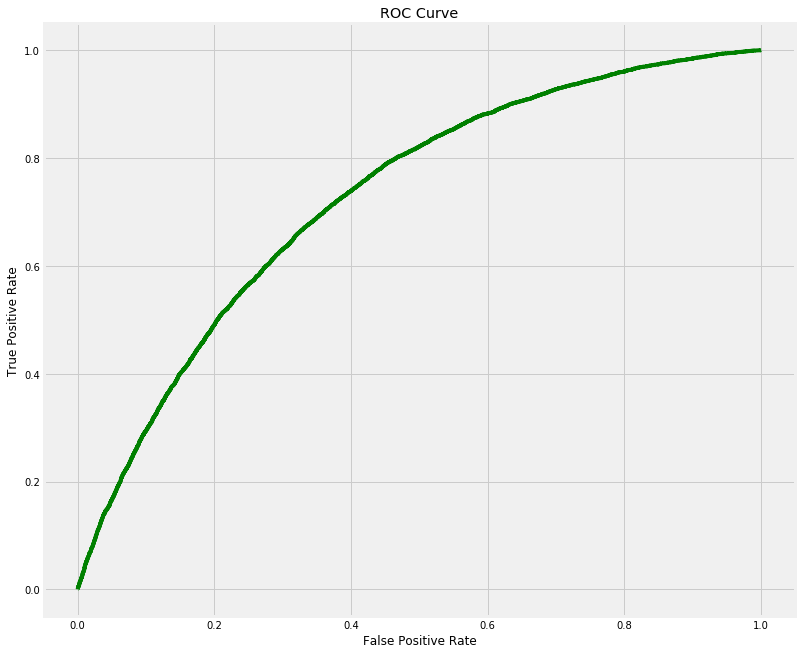

In [86]:
fig = plt.figure(figsize=(12,24))
ax = fig.add_subplot(2,1,2)
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.plot(tpr, fpr, c='g', label="Logistic with LSA")

To improve, I might try word embedding with RNN in the future.